# OCR
이미지 속에서 영문을 Bounding box로 찾아내고, 그 Bounding box내에 어떤 Text가 포함되는지 알 수 있는 시스템.  
Text Detection : Segmentation 기반의 **CRAFT**를 활용한 **keras-ocr** 활용.  
Recognition : keras-ocr을 사용하지 않고 직접 만듬.  

참고 : [keras-ocr](https://github.com/faustomorales/keras-ocr)  

---

**사용 데이터셋**  
Recgnition model의 정량적인 평가를 위해 `MJSynth`와 `SynthText`라는 데이터셋 활용.  
참고 : 
[MJSynth](https://www.robots.ox.ac.uk/~vgg/data/text/), 
[SynthText](https://www.robots.ox.ac.uk/~vgg/data/scenetext/)

## Recognition model  
CRNN 구조를 활용해서 만듬.  
참고 : [An End-to-End Trainable Neural Network for Image-based SequenceRecognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# 몇개의 class가 필요한지 확인 
# -> 영문 대문자와 숫자를 인식하기 위해서는 36개의 클래스 필요
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
# 필요한 라이브러리 import 
import re
import six
import math
import lmdb
import os
import numpy as np


from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/home/ssac12/aiffel/ocr/MJ/MJ_train


## Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


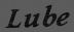

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


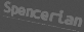

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


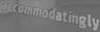

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


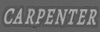

In [4]:
# imdb를 통해 훈련 데이터셋의 이미지를 4개만 열어 shape, 이미지, 라벨을 확인 
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

## Encode
이전 스텝에서 확인한 Label은 우리(사람)가 읽을 수 있는 평문으로 이루어져 있었음.  
이는 모델에 학습하기 위한 적절한 형태가 아니므로, 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 함.  
`LabelConverter`클래스는 이를 수행한다.

In [6]:
class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character): # 입력 받은 text의 각 character들이 어떤 index에 매핑되는지 저장.
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     # 각 index를 다시 character로 변환하여 사람이 읽을 수 있는 text로 바꾸어줌. 
     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Build CRNN model
keras의 `K.ctc_batch_cost()` 를 활용해 loss를 계산 하도록 `ctc_lambda_func` 만듬.  

---

**`K.ctc_batch_cost()`함수**  
4개의 인자를 가짐
- `y_true` : 실제 라벨 정보를 포함하는 tensor(samples, max_string_length)
- `y_pred` : 예측 라벨 정보를 포함하는 tensor(samples, time_steps, num_categories)
- `input_length tensor` : y_pred의 각 배치 항목에 대한 시퀀스 길이 포함
- `label_length tensor` : y_true의 각 배치 항목에 대한 시퀀스 길이 포함

참고 : [Tensorflow Tutorial - ctx_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

## Train & Inference
앞서 정의한 `MJDatasetSequence`로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 수행.   
이후 `decode_predict_ctc`를 통해 학습한 모델을 테스트셋에서 inference해보고 확인 

In [10]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 29.4186
Epoch 00001: val_loss improved from inf to 26.97749, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 134ms/step - loss: 29.4186 - val_loss: 26.9775
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 26.3990
Epoch 00002: val_loss improved from 26.97749 to 26.95974, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 129ms/step - loss: 26.3990 - val_loss: 26.9597
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 26.0436
Epoch 00003: val_loss improved from 26.95974 to 26.55317, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 123ms/step - loss: 26.0436 - val_loss: 26.5532
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 25.6270
Epoch 00004: val_loss improved from 26.55317 to 25.99429, saving

Epoch 31/100
63/63 [==============================] - ETA: 0s - loss: 5.6134
Epoch 00031: val_loss improved from 5.92595 to 5.80893, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 5.6134 - val_loss: 5.8089
Epoch 32/100
63/63 [==============================] - ETA: 0s - loss: 5.4532
Epoch 00032: val_loss improved from 5.80893 to 5.73656, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 5.4532 - val_loss: 5.7366
Epoch 33/100
63/63 [==============================] - ETA: 0s - loss: 5.3841
Epoch 00033: val_loss improved from 5.73656 to 5.43603, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 5.3841 - val_loss: 5.4360
Epoch 34/100
63/63 [==============================] - ETA: 0s - loss: 5.2501
Epoch 00034: val_loss improved from 5.43603 to 5.33139, saving model to

Epoch 64/100
63/63 [==============================] - ETA: 0s - loss: 3.4918
Epoch 00064: val_loss did not improve from 3.64109
63/63 [==============================] - 8s 126ms/step - loss: 3.4918 - val_loss: 3.7485
Epoch 65/100
63/63 [==============================] - ETA: 0s - loss: 3.5229
Epoch 00065: val_loss improved from 3.64109 to 3.60945, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 3.5229 - val_loss: 3.6095
Epoch 66/100
63/63 [==============================] - ETA: 0s - loss: 3.4617
Epoch 00066: val_loss improved from 3.60945 to 3.56442, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 126ms/step - loss: 3.4617 - val_loss: 3.5644
Epoch 67/100
63/63 [==============================] - ETA: 0s - loss: 3.3474
Epoch 00067: val_loss did not improve from 3.56442
63/63 [==============================] - 8s 125ms/step - loss: 3.3474 - val_loss: 3.567

Epoch 97/100
63/63 [==============================] - ETA: 0s - loss: 2.8443
Epoch 00097: val_loss improved from 2.97559 to 2.88096, saving model to /home/ssac12/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 8s 127ms/step - loss: 2.8443 - val_loss: 2.8810
Epoch 98/100
63/63 [==============================] - ETA: 0s - loss: 2.7822
Epoch 00098: val_loss did not improve from 2.88096
63/63 [==============================] - 8s 126ms/step - loss: 2.7822 - val_loss: 3.0654
Epoch 99/100
63/63 [==============================] - ETA: 0s - loss: 2.8095
Epoch 00099: val_loss did not improve from 2.88096
63/63 [==============================] - 8s 131ms/step - loss: 2.8095 - val_loss: 3.2208
Epoch 100/100
63/63 [==============================] - ETA: 0s - loss: 2.7679
Epoch 00100: val_loss did not improve from 2.88096
63/63 [==============================] - 9s 139ms/step - loss: 2.7679 - val_loss: 2.8863


(1, 100, 32, 3)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Result: 	 SLINKING9999999999999999


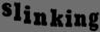

(1, 100, 32, 3)
Result: 	 ALEPPO99999999999999999


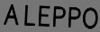

(1, 100, 32, 3)
Result: 	 RWANDA999999999999999999


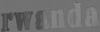

(1, 100, 32, 3)
Result: 	 NATHANS99999999999999999


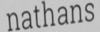

(1, 100, 32, 3)
Result: 	 HALLBO99999999999999999


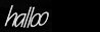

(1, 100, 32, 3)
Result: 	 HURLS9999999999999999999


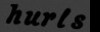

(1, 100, 32, 3)
Result: 	 DOWNSIZE9999999999999999


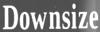

(1, 100, 32, 3)
Result: 	 ROBOTIC99999999999999999


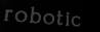

(1, 100, 32, 3)
Result: 	 SLOPPY99999999999999999


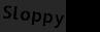

(1, 100, 32, 3)
Result: 	 HERMITE99999999999999999


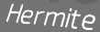

In [11]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        print(img.shape)
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

# End-to-End OCR
keras-ocr의 Detector를 활용.  
[detection.py](https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/detection.py)내에 있는 Detector 클래스(line 651)의 객체를 생성 후,  
Detect.detect를 호출하여 text가 있는 위치의 boxes값을 가져옴. 


In [12]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras_ocr.detection import Detector
SAMPLE_IMG_PATH = HOME_DIR+ '/sample.jpg'

detector = Detector()


def detect_text(img_path):
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result=detector.detect(input_img)
    #print("result", result, "\n")
    ocr_result = result[0]
    #print("ocr_result", ocr_result, "\n")
    cropped_imgs = []
    for text_result in ocr_result:
        #print("text_result", text_result, "\n")
        for i in range(4):
            if i==3:
                # cv2.line(image, start_point, end_point, color, thickness)
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    return line_img, cropped_imgs

Looking for /home/ssac12/.keras-ocr/craft_mlt_25k.h5


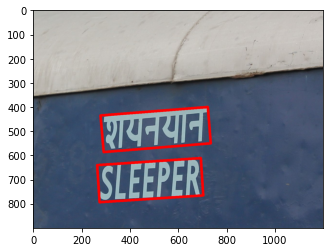

In [13]:
img, cropped_img = detect_text(SAMPLE_IMG_PATH)
#print(img.shape)
plt.imshow(img[:,:,::-1]) # flipping the color form BGR to RGB

`decode_predict_ctc`의 입력 이미지의 shape는 (1,100,32,3)이여야만 함.   
따라서 input이미지의 shape를 변경해주는 과정이 필요함. 

In [14]:
# 이미지를 input_img_size에 맞게 resize하기 위해 array -> img로 변환 후 resize
def array_to_img(array,input_img_size = (100,32)):
    img = Image.fromarray(array, 'RGB')
    img = img.resize(input_img_size)
    return img

In [15]:
# 위의 check_inference 참고
def recognize_img(pil_img, input_img_size=(100,32)):
    pil_img = array_to_img(pil_img) # resize한 img를 다시 array로 변환
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1,0,2))
    np_img = np_img[np.newaxis, :, :, :]  


    output = model_pred.predict(np_img)
    
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    
    result = re.sub(r'\d', '', result) # 결과에서 숫자를 제외하고 출력하기 위함 
    print("Result: \t", result)
    display(Image.fromarray(np_img[0].transpose(1,0,2).astype(np.uint8)))

(196, 466, 3)
Result: 	 REFUF


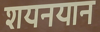

(192, 449, 3)
Result: 	 SLEEPER


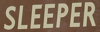

In [16]:
for _img in cropped_img:
    print(_img.shape)
    #_img.shape가 y,x,c라는 것을 확인 가능 
    recognize_img(_img)

다른 이미지에서도 잘 동작하는지 확인

In [17]:
# file_list 추출 참고 : https://itholic.github.io/python-listdir-glob/
import matplotlib.image as mpimg

def ocr_test():
    file_list = os.listdir(HOME_DIR)
    print(file_list)
    file_list_img = [file for file in file_list if file.endswith(".png")]
    print ("file_list_img: {}".format(file_list_img))
    
    for path in file_list_img:
        SAMPLE_IMG_PATH = HOME_DIR +"/" +path
        img, cropped_img = detect_text(SAMPLE_IMG_PATH)
        imgs = mpimg.imread(SAMPLE_IMG_PATH)
        imgplot = plt.imshow(imgs)
        plt.show()
        for _img in cropped_img:
            recognize_img(_img)

['model_checkpoint.hdf5', 'test2.png', 'test.png', 'MJ', 'sample.jpg']
file_list_img: ['test2.png', 'test.png']


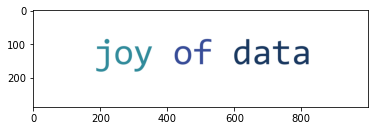

Result: 	 DATA


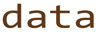

Result: 	 OF


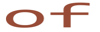

Result: 	 JOY


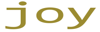

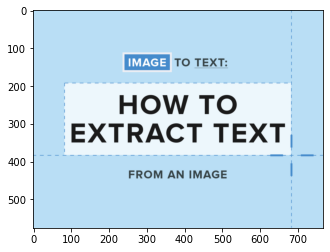

Result: 	 MGE


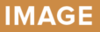

Result: 	 FO


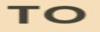

Result: 	 TEXT


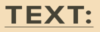

Result: 	 HOW


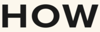

Result: 	 TO


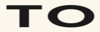

Result: 	 EXTRACT


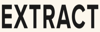

Result: 	 TEXT


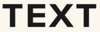

Result: 	 FROM


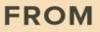

Result: 	 ARJ


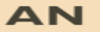

Result: 	 IMAGE


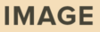

In [18]:
ocr_test()